In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# mi tengo da parte le colonne per comodità

# cols = ['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills' , 'blueDeaths',
#        'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
#        'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff',
#        'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood',
#        'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
#        'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled',
#        'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']

df = pd.read_csv('high_diamond_ranked_10min.csv', index_col=False)
cols = df.columns.values

print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [2]:
# EDA

# non ho campioni nulli da gestire e tutte le colonne sono del DType corretto

print(df.groupby('blueWins')['blueWins'].count())
# il dataset è bilanciato

vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
print(vif_data)

blueWins
0    4949
1    4930
Name: blueWins, dtype: int64


C:\Users\utente\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                         feature           VIF
0                         gameId  1.007735e+00
1                       blueWins  1.391591e+00
2                blueWardsPlaced  1.027022e+00
3             blueWardsDestroyed  1.068598e+00
4                 blueFirstBlood  7.402307e+03
5                      blueKills  2.251800e+15
6                     blueDeaths  1.125900e+15
7                    blueAssists  3.770069e+00
8              blueEliteMonsters           inf
9                    blueDragons           inf
10                   blueHeralds           inf
11           blueTowersDestroyed  1.612476e+00
12                 blueTotalGold           inf
13                  blueAvgLevel  5.376939e+00
14           blueTotalExperience           inf
15        blueTotalMinionsKilled           inf
16  blueTotalJungleMinionsKilled  1.858109e+00
17                  blueGoldDiff           inf
18            blueExperienceDiff           inf
19                  blueCSPerMin  1.501200e+15
20           

In [3]:
# I valori *perMin non servono a nulla, so che i dati provengono da 10 min di partita e ho a disposizione direttamente i
# totali -> tolte blueCSPerMin, redCSPerMin, blueGoldPerMin e redGoldPerMin.

# Le differenze tra gold ed exp. dei team sono solo di segno opposto e provengono dalle differenze dei valori totali
# -> tolte blueGoldDiff, redGoldDiff, blueExpDiff e redExpDiff.

# La first blood non ha senso separarla per squadre, ne basta una -> tolta redFirstKill, se blueFirstBlood = 1 è del
# team blue, altrimenti è del team rosso.

# Stesso ragionamento per le kill/deaths, ogni uccisione per un team è una morte per l'altro -> tolte redKill e redDeaths.

# Il livello dei personaggi è una funzione dell'esperienza totale, non mi serve mantenere una media dei livelli tra i
# personaggi -> tolto blueAvgLevel e redAvgLevel.

# Elite monsters è la somma di dragons e herald -> tolto blueEliteMonsters e redEliteMonsters.

# gameId serve come identificatore delle partite, non necessario.

# wardsPlaced e wardsDestroyed non sono importanti, lo conosco a priori e guardando la correlazione tra le feature si
# vede come non ha praticamente effetto su nulla , sta nell'ordine di 0.00qualcosa
# -> tolto blueWardsPlaced, blueWardsDestroyed, redWardsPlaced e redWardsDestroyed

df_final = df[['blueWins', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'redAssists',
        'blueDragons', 'blueHeralds', 'blueTowersDestroyed',  'redDragons', 'redHeralds', 'redTowersDestroyed',
        'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
        'redTotalGold', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']]

corr_df_final = df_final.corr()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(corr_df_final)

vif_data = pd.DataFrame()
vif_data["feature"] = df_final.columns
vif_data["VIF"] = [variance_inflation_factor(df_final.values, i) for i in range(len(df_final.columns))]
print(vif_data)

                              blueWins  blueFirstBlood  blueKills  blueDeaths  \
blueWins                      1.000000        0.201769   0.337358   -0.339297   
blueFirstBlood                0.201769        1.000000   0.269425   -0.247929   
blueKills                     0.337358        0.269425   1.000000    0.004044   
blueDeaths                   -0.339297       -0.247929   0.004044    1.000000   
blueAssists                   0.276685        0.229485   0.813667   -0.026372   
redAssists                   -0.271047       -0.201140  -0.020344    0.804023   
blueDragons                   0.213768        0.134309   0.170436   -0.188852   
blueHeralds                   0.092385        0.077509   0.076195   -0.095527   
blueTowersDestroyed           0.115566        0.083316   0.180314   -0.071441   
redDragons                   -0.209516       -0.135327  -0.207949    0.150746   
redHeralds                   -0.097172       -0.060246  -0.104423    0.076639   
redTowersDestroyed          

                         feature          VIF
0                       blueWins     2.775071
1                 blueFirstBlood     2.557039
2                      blueKills    57.724600
3                     blueDeaths    56.589931
4                    blueAssists    13.535050
5                     redAssists    13.071310
6                    blueDragons     2.757887
7                    blueHeralds     1.387352
8            blueTowersDestroyed     1.567334
9                     redDragons     3.046534
10                    redHeralds     1.343018
11            redTowersDestroyed     1.498222
12                 blueTotalGold  1581.871393
13           blueTotalExperience  1041.005159
14        blueTotalMinionsKilled   288.059686
15  blueTotalJungleMinionsKilled    46.452925
16                  redTotalGold  1547.719642
17            redTotalExperience  1037.772221
18         redTotalMinionsKilled   285.700872
19   redTotalJungleMinionsKilled    47.734008


                feature        VIF
0              blueWins   2.707733
1        blueFirstBlood   2.340851
2   blueKills/redDeaths  18.392969
3   blueDeaths/redKills  17.769415
4           blueAssists  11.422658
5            redAssists  10.940964
6           blueDragons   2.743856
7           blueHeralds   1.383818
8            blueTowers   1.157973
9            redDragons   3.032979
10           redHeralds   1.339524
11            redTowers   1.144244
12          blueMinions  82.989576
13    blueJungleMinions  29.240864
14           redMinions  82.345748
15     redJungleMinions  29.109428


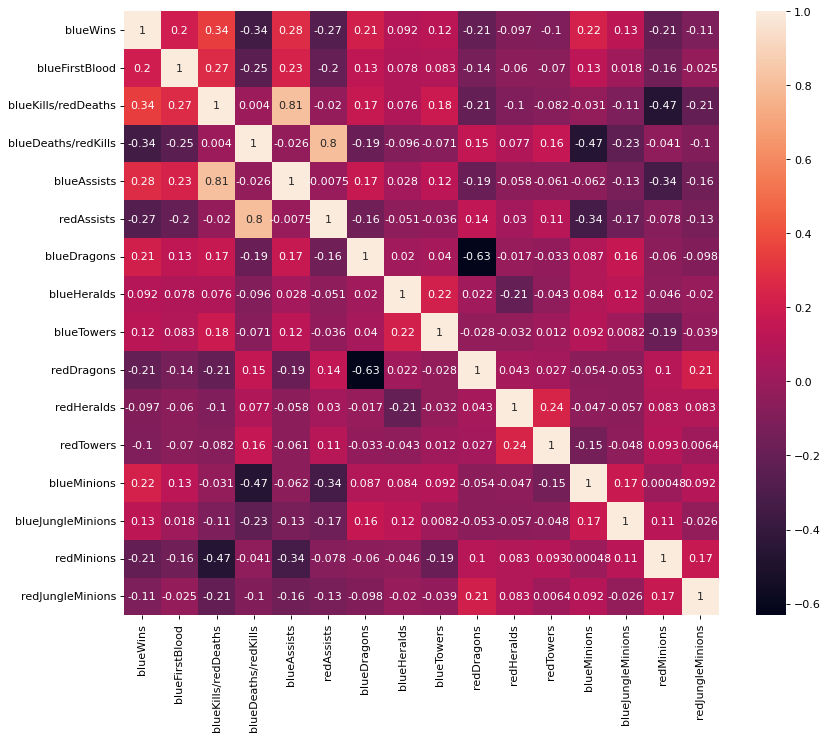

In [4]:
# pensavo di tenere totalGold e totalExp per questioni di explainability, sono le cose che si comprendono meglio per prevedere
# una vittoria o meno e sono quelle più correlate a blueWins, ma sono anche delle funzioni di tutto il resto:

# totalGold = passiveGold(7294g in 10 min) + goldFromKills + goldFromAssists + goldFromMinions + goldFromJungle+ goldFromTowers
# totalExp = expFromKills + expFromMinions + expFromJungle

df_final = df[['blueWins', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'redAssists',
        'blueDragons', 'blueHeralds', 'blueTowersDestroyed',  'redDragons', 'redHeralds', 'redTowersDestroyed',
        'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
        'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']]

df_final = df_final.rename(columns={"blueKills": "blueKills/redDeaths", "blueDeaths": "blueDeaths/redKills",
        "blueTotalMinionsKilled": "blueMinions", "blueTotalJungleMinionsKilled": "blueJungleMinions",
        "redTotalMinionsKilled": "redMinions", "redTotalJungleMinionsKilled": "redJungleMinions",
        "blueTowersDestroyed": "blueTowers", "redTowersDestroyed": "redTowers"})

# cols_final = ['blueWins', 'blueFirstBlood', 'blueKills/redDeaths',
#        'blueDeaths/redKills', 'blueAssists', 'redAssists', 'blueDragons',
#       'blueHeralds', 'blueTowers', 'redDragons', 'redHeralds', 'redTowers',
#       'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions']

vif_data = pd.DataFrame()
vif_data["feature"] = df_final.columns
vif_data["VIF"] = [variance_inflation_factor(df_final.values, i) for i in range(len(df_final.columns))]
print(vif_data)

figure(figsize=(12, 10), dpi=80)
corr_df_final = df_final.corr()
sns.heatmap(corr_df_final, annot=True)
plt.show()

# dopo i tagli delle feature, il VIF è sceso di molto, ma dalla teoria so che valori di VIF > 5 solitamente indicano collinearità

# per quanto riguarda i minion, se non avvenissero kill, il limite massimo per ogni squadra dovrebbe essere 
# intorno ai 321 normali più circa 70 dalla jungle.

# dopo una kill, un campione respawna in base e non potrà fare minion per alcuni secondi, perciò posso stimare che per
# ad ogni kill corrisponda una perdita di circa 7-10 minion rispetto al massimo.
# riesco quindi a stimare quanti sono i minion totali per ogni squadra, ragionamento simile per i minion della jungle.

# potrei quindi togliere le 4 feature di blue/redMinions e blue/redJungleMinions, ma preferirei non farlo, voglio mantere queste
# feature perchè mi fanno calcolare in maniera precisa gold ed exp per squadra, che so essere importanti per
# determinare chi vinca, sono le feature più correlate a blueWins infatti, non voglio rendere questi aspetti del problema 
# troppo nascosti

In [5]:
duplicateRows = df_final[df_final.duplicated()]
print(duplicateRows)

# nonostante i tagli di feature, non ci sono duplicati nel dataset

Empty DataFrame
Columns: [blueWins, blueFirstBlood, blueKills/redDeaths, blueDeaths/redKills, blueAssists, redAssists, blueDragons, blueHeralds, blueTowers, redDragons, redHeralds, redTowers, blueMinions, blueJungleMinions, redMinions, redJungleMinions]
Index: []


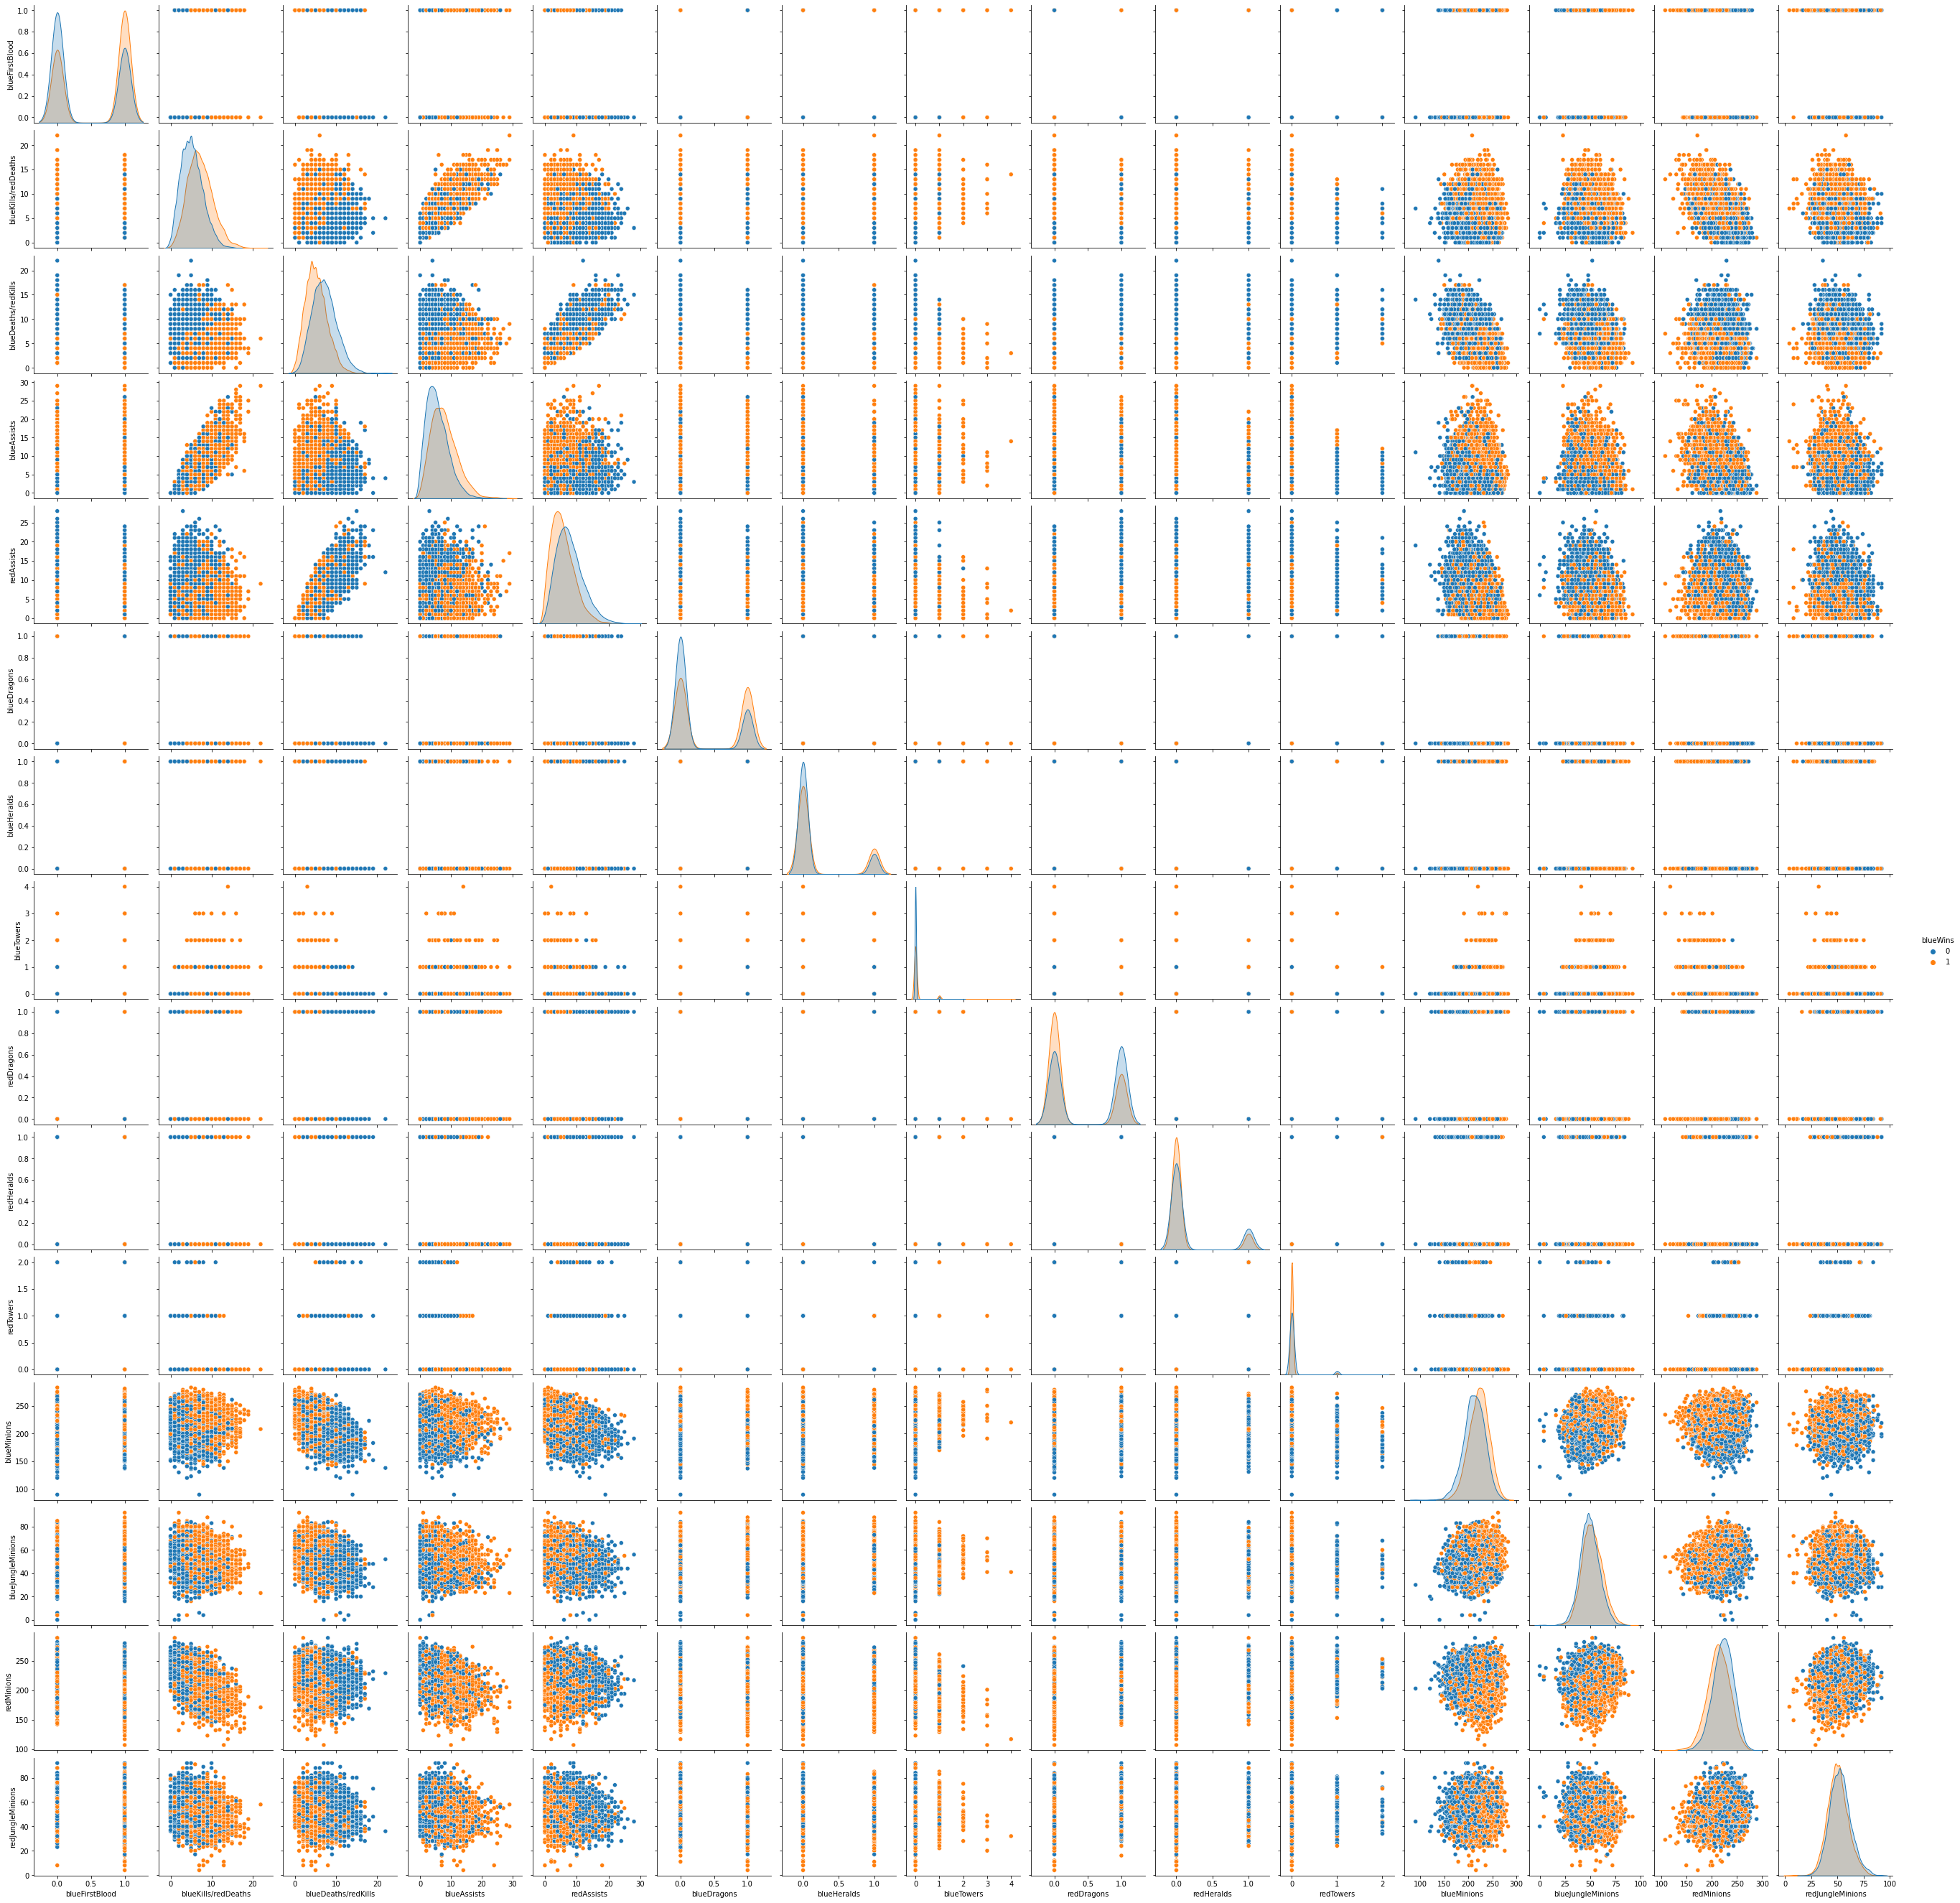

In [6]:
sns.pairplot(df_final, hue='blueWins')
plt.show()

In [7]:
X = df_final.drop('blueWins', axis=1)
t = df_final[['blueWins']]

X = pd.DataFrame(X, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
                            'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions',
                            'blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds'])

cols_final = X.columns.values

validation_split = 0.6
development_split =0.7
test_split = 0.8

tr_size = int(X.shape[0]*validation_split)
val_size = int(X.shape[0]*development_split)
dev_size = int(X.shape[0]*test_split)

X_tr = X[0:tr_size]
t_tr = t[0:tr_size]

X_val = X[tr_size:val_size]
t_val = t[tr_size:val_size]

X_dev = X[val_size:dev_size]
t_dev = t[val_size:dev_size]

X_te = X[dev_size:]
t_te = t[dev_size:]

In [8]:
# Normalizzazione train set

# le feature FirstBlood, blueDragons, redDragons, blueHerald, redHeraldtutte sono categoriche, non le normalizzo
# le altre sono numeriche discrete, contano il numero di *, le normalizzo
temp1 = X_tr[['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds']]
X_tr = X_tr.drop(['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds'], axis=1)

scaler = MinMaxScaler()
X_tr_norm = scaler.fit_transform(X_tr)

X_tr_norm = pd.DataFrame(X_tr_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])

X_tr_norm_final = pd.concat([X_tr_norm, temp1], axis=1)
X_tr_norm_final = X_tr_norm_final[cols_final]

In [9]:
# Normalizzazione validation set
temp2 = X_val[['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds']]
X_val = X_val.drop(['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds'], axis=1)

X_val_norm = scaler.transform(X_val)

X_val_norm = pd.DataFrame(X_val_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])
temp2_reset = temp2.reset_index()

X_val_norm_final = pd.concat([X_val_norm, temp2_reset], axis=1)
X_val_norm_final = X_val_norm_final[cols_final]

In [10]:
# Model Selection

# plottare come evolvono errori/performance sul train e sulla validation, mostrare se sto overfittando o no confrontando
# errore sul train contro errore sul validation, poi l'f1score che prendo è comunque quello che funziona meglio sul validation

# Sometimes, you can see useful differences in performance or convergence with different solvers (solver).
#    solver in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
# Regularization (penalty) can sometimes be helpful.
#    penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
# Note: not all solvers support all regularization terms, l2 default supported by all
# The C parameter controls the penality strength, which can also be effective.

C_range = np.logspace(-3.0, 3.0, num=7)

maxf1score_logistic = 0.0
maxC_logistic = 0.0
best_solver_logistic = ''

f1scores_tr = []
f1scores_val = []
k_par = []

best_predictions = []

for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
    for k in C_range:
    
        print('Im working on: ', solver, ', ', k, '\n')
        logistic_model = LogisticRegression(solver= solver, penalty= 'l2', C= k)
        logistic_model.fit(X_tr_norm_final, t_tr)
        
        t_hat = logistic_model.predict(X_tr_norm_final)
        f1score_tr = f1_score(t_tr, t_hat, average='macro')
        
        t_pred = logistic_model.predict(X_val_norm_final)
        f1score = f1_score(t_val, t_pred, average='macro')

        k_par.append(k)
        f1scores_tr.append(f1score_tr)
        f1scores_val.append(f1score)
            
        if f1score > maxf1score_logistic:
            maxf1score_logistic = f1score
            maxC_logistic = k
            best_solver_logistic = solver
            best_predictions = t_pred

print(maxf1score_logistic, maxC_logistic, best_solver_logistic)

#0.71556344211388 0.1 liblinear


Im working on:  lbfgs ,  0.001 

Im working on:  lbfgs ,  0.01 

Im working on:  lbfgs ,  0.1 

Im working on:  lbfgs ,  1.0 

Im working on:  lbfgs ,  10.0 

Im working on:  lbfgs ,  100.0 

Im working on:  lbfgs ,  1000.0 

Im working on:  liblinear ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Im working on:  liblinear ,  0.01 

Im working on:  liblinear ,  0.1 

Im working on:  liblinear ,  1.0 

Im working on:  liblinear ,  10.0 

Im working on:  liblinear ,  100.0 

Im working on:  liblinear ,  1000.0 

Im working on:  newton-cg ,  0.001 

Im working on:  newton-cg ,  0.01 

Im working on:  newton-cg ,  0.1 

Im working on:  newton-cg ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Im working on:  newton-cg ,  10.0 

Im working on:  newton-cg ,  100.0 

Im working on:  newton-cg ,  1000.0 

Im working on:  sag ,  0.001 

Im working on:  sag ,  0.01 

Im working on:  sag ,  0.1 

Im working on:  sag ,  1.0 

Im working on:  sag ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Im working on:  sag ,  100.0 

Im working on:  sag ,  1000.0 

Im working on:  saga ,  0.001 

Im working on:  saga ,  0.01 

Im working on:  saga ,  0.1 

Im working on:  saga ,  1.0 

Im working on:  saga ,  10.0 

Im working on:  saga ,  100.0 

Im working on:  saga ,  1000.0 

0.71556344211388 0.1 liblinear


C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

<Figure size 432x288 with 0 Axes>

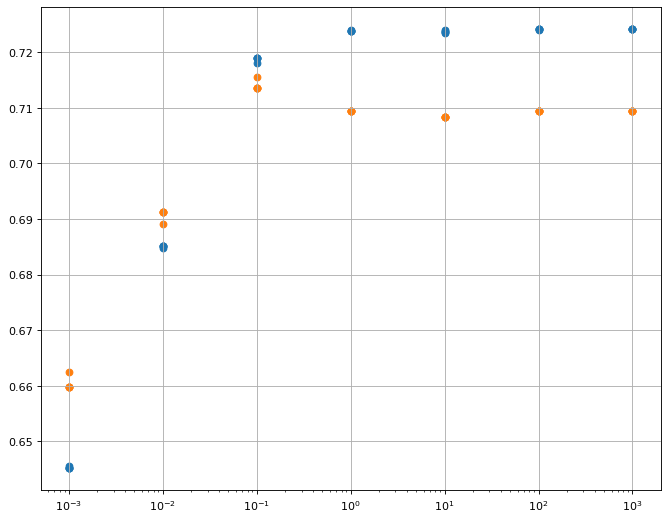

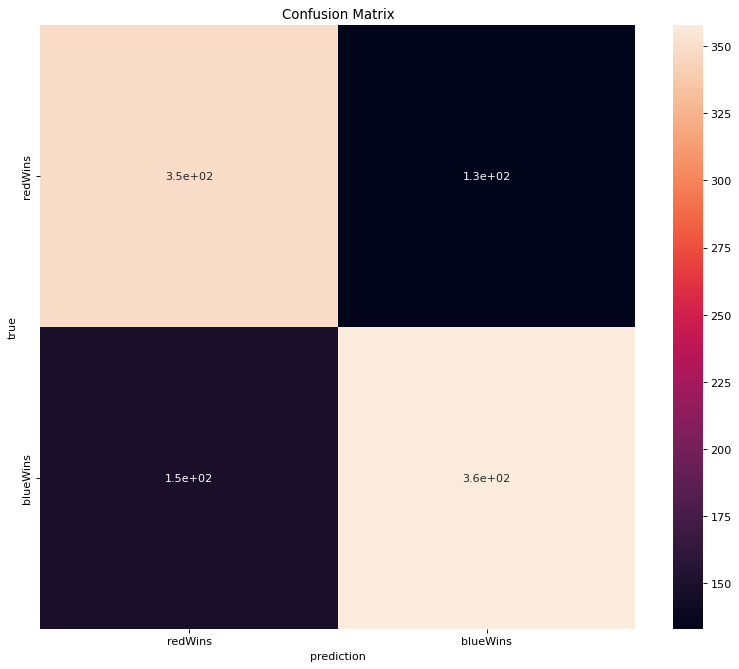

In [11]:
fig = plt.figure()
figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
ax.scatter(k_par, f1scores_tr) # blue
ax.scatter(k_par, f1scores_val) # orange
ax.set_xscale('log')
ax.grid(True)
plt.show()

# per iperparametri oltre 0.1 si va in overfitting, errore sul validation set sale mentre scende quello sul training
# qua ho plottato f1score e non errore, ma so che più è alto f1score e meglio è la mia classificazione
# vedo anche che i diversi ottimizzatori non sono troppo diversi tra di loro

cm = confusion_matrix(t_val, best_predictions)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm, annot=True, xticklabels=['redWins', 'blueWins'], yticklabels=['redWins', 'blueWins'])
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

Im working on:  linear ,  1 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  1 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  2 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  3 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  4 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  linear ,  5 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  1 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  2 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  3 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  4 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  poly ,  5 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  1 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  2 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  0.01 

Im working on:  rbf ,  3 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  3 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  4 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  rbf ,  5 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  1 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  0.001 

Im working on:  sigmoid ,  2 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  2 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  3 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  4 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  0.001 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  0.01 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  0.1 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  1.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  10.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  100.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.001 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.01 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  0.1 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  10.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  100.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Im working on:  sigmoid ,  5 ,  1000.0 ,  1000.0 



C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


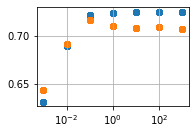

<Figure size 640x480 with 0 Axes>

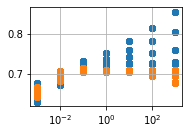

<Figure size 640x480 with 0 Axes>

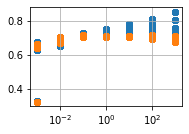

<Figure size 640x480 with 0 Axes>

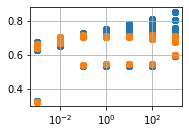

<Figure size 640x480 with 0 Axes>

0.7165945449777078 0.1 linear 1 0.001


In [12]:
# Perhaps the first important parameter is the choice of kernel that will control the manner in which the input variables 
# will be projected. There are many to choose from, but linear, polynomial, 
# and RBF are the most common, perhaps just linear and RBF in practice.
#    kernels in [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’]
# If the polynomial kernel works out, then it is a good idea to dive into the degree hyperparameter. Ignored by other kernels
# Another critical parameter is the penalty (C) that can take on a range of values and has a dramatic effect
# on the shape of the resulting regions for each class. A log scale might be a good starting point.

gamma_range = np.logspace(-3.0, 3.0, num=7)

maxf1score_svm = 0.0
maxC_svm = 0.0
best_kernel_svm = ''
best_degree = 0
best_gamma = 0.0


i= 1
f1scores_tr_svm = []
f1scores_val_svm = []
k_par_svm = []

best_predictions_svm = []

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for degree in range(1, 6):
        for gamma in gamma_range:
            for k in C_range:
            
                print('Im working on: ', kernel, ', ', degree, ', ', k, ', ', gamma, '\n')
            
                svm_model = SVC(kernel= kernel, C= k, degree= degree)
                svm_model.fit(X_tr_norm_final, t_tr)
                
                t_hat = svm_model.predict(X_tr_norm_final)
                t_pred = svm_model.predict(X_val_norm_final)
                f1score_tr = f1_score(t_tr, t_hat, average='macro')
                f1score = f1_score(t_val, t_pred, average='macro')

                f1scores_tr_svm.append(f1score_tr)
                f1scores_val_svm.append(f1score)
                k_par_svm.append(k)
                
                if f1score > maxf1score_svm:
                    maxf1score_svm = f1score
                    maxC_svm = k
                    best_kernel_svm = kernel
                    best_degree = degree
                    best_gamma = gamma
                    best_predictions_svm = t_pred
    
    
    fig = plt.figure()
    figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(2, 2, i)
    ax.scatter(k_par_svm, f1scores_tr_svm)
    ax.scatter(k_par_svm, f1scores_val_svm)
    ax.set_xscale('log')
    ax.grid(True)
    i = i+1

plt.show()
print(maxf1score_svm, maxC_svm, best_kernel_svm, best_degree, best_gamma)
#0.7165945449777078 0.1 linear 1 0.001

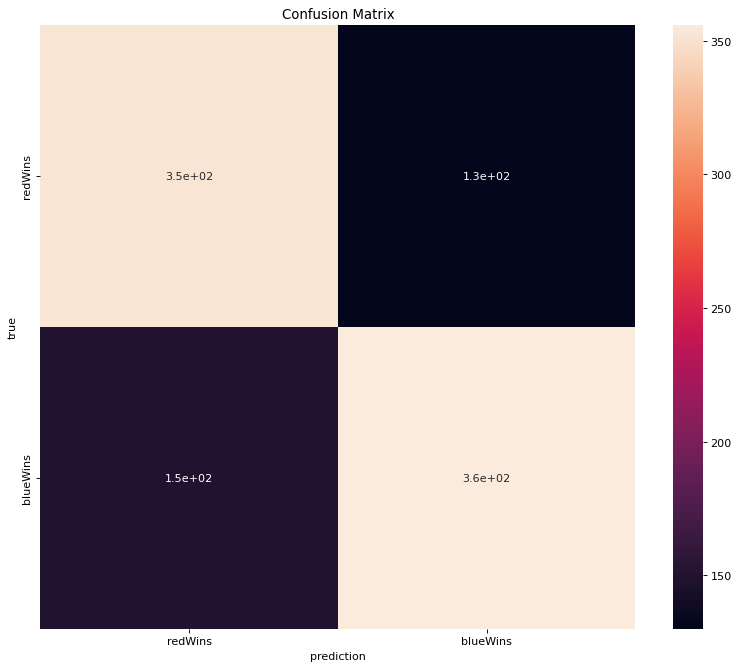

In [13]:
cm = confusion_matrix(t_val, best_predictions_svm)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm, annot=True, xticklabels=['redWins', 'blueWins'], yticklabels=['redWins', 'blueWins'])
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

In [14]:
# Normalizzazione development set

X_tr_new = pd.concat([X_tr, X_val])
t_tr_new = pd.concat([t_tr, t_val])

dev_scaler = MinMaxScaler()
X_tr_new_norm = dev_scaler.fit_transform(X_tr_new)
X_tr_new_norm = pd.DataFrame(X_tr_new_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])

temp_new = pd.concat([temp1, temp2])
X_tr_norm_new_final = pd.concat([X_tr_new_norm, temp_new], axis=1)
X_tr_norm_new_final = X_tr_norm_new_final[cols_final]


temp3 = X_dev[['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds']]
X_dev = X_dev.drop(['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds'], axis=1)

X_dev_norm = dev_scaler.transform(X_dev)

X_dev_norm = pd.DataFrame(X_dev_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])
temp3_reset = temp3.reset_index()

X_dev_norm_final = pd.concat([X_dev_norm, temp3_reset], axis=1)
X_dev_norm_final = X_dev_norm_final[cols_final]

In [15]:
# mi salvo gli iperparametri ottimi per non dover eseguire ogni volta quei blocchi
#maxC_logistic = 0.1
#best_solver_logistic = 'liblinear'

#maxC_svm = 0.1 
#best_kernel_svm = 'linear'
#best_degree = 1
#best_gamma = 0.001
    
logistic_model_val = LogisticRegression(solver= best_solver_logistic, penalty= 'l2', C= maxC_logistic)
logistic_model_val.fit(X_tr_norm_new_final, t_tr_new)    
t_pred_logistic = logistic_model_val.predict(X_dev_norm_final)
f1score_logistic = f1_score(t_dev, t_pred_logistic, average='macro')
 
svm_model_val = SVC(kernel= best_kernel_svm, C= maxC_svm, degree= best_degree)
svm_model_val.fit(X_tr_norm_new_final, t_tr_new)
t_pred_svm = svm_model_val.predict(X_dev_norm_final)   
f1score_svm = f1_score(t_dev, t_pred_svm, average='macro')

print('the scores are: for logistic ', f1score_logistic, ' and for svm ', f1score_svm)
#for logistic  0.7336853530223848  and for svm  0.7356021667112682

C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


the scores are: for logistic  0.7336853530223848  and for svm  0.7356021667112682


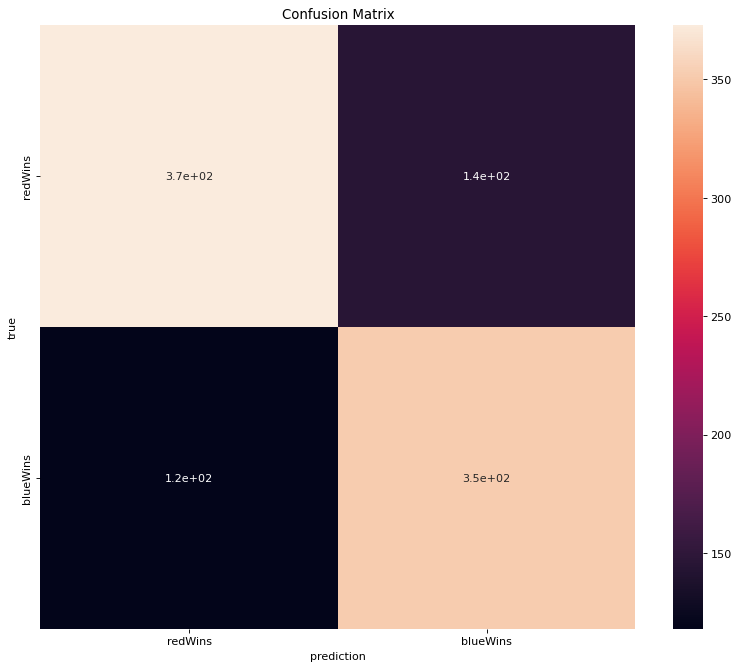

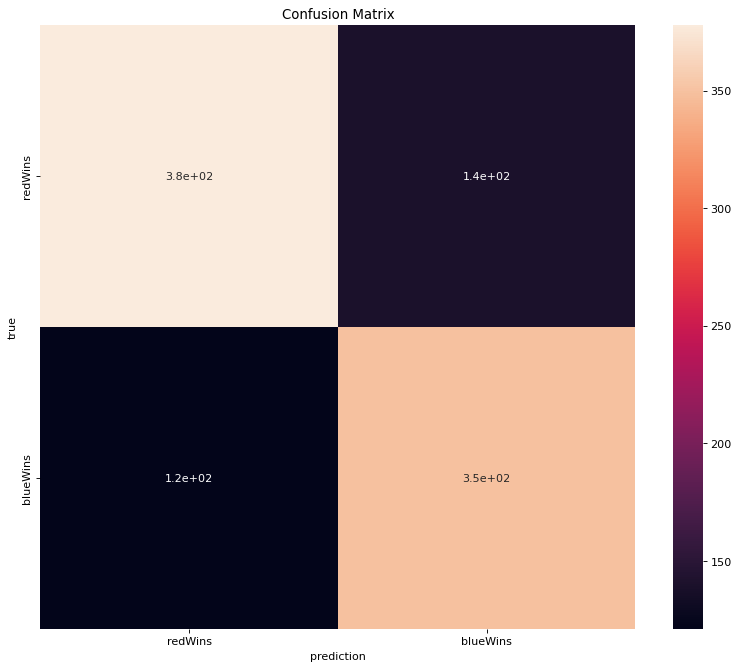

In [16]:
cm = confusion_matrix(t_dev, t_pred_logistic)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm, annot=True, xticklabels=['redWins', 'blueWins'], yticklabels=['redWins', 'blueWins'])
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

cm = confusion_matrix(t_dev, t_pred_svm)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm, annot=True, xticklabels=['redWins', 'blueWins'], yticklabels=['redWins', 'blueWins'])
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

In [17]:
# Normalizzazione test set
X_tr_last = pd.concat([X_tr, X_val, X_dev])
t_tr_last = pd.concat([t_tr, t_val, t_dev])

dev_scaler = MinMaxScaler()
X_tr_last_norm = dev_scaler.fit_transform(X_tr_last)
X_tr_last_norm = pd.DataFrame(X_tr_last_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])

temp_last = pd.concat([temp1, temp2, temp3])
X_tr_norm_last_final = pd.concat([X_tr_last_norm, temp_last], axis=1)
X_tr_norm_last_final = X_tr_norm_last_final[cols_final]


temp4 = X_te[['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds']]
X_te = X_te.drop(['blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons', 'redHeralds'], axis=1)

X_te_norm = dev_scaler.transform(X_te)

X_te_norm = pd.DataFrame(X_te_norm, columns = ['blueKills/redDeaths', 'blueDeaths/redKills', 'blueAssists', 'redAssists', 
        'blueTowers', 'redTowers', 'blueMinions', 'blueJungleMinions', 'redMinions', 'redJungleMinions'])
temp4 = temp4.reset_index()

X_te_norm_final = pd.concat([X_te_norm, temp4], axis=1)
X_te_norm_final = X_te_norm_final[cols_final]

C:\Users\utente\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


the f1score on the test set is:  0.7356021667112682


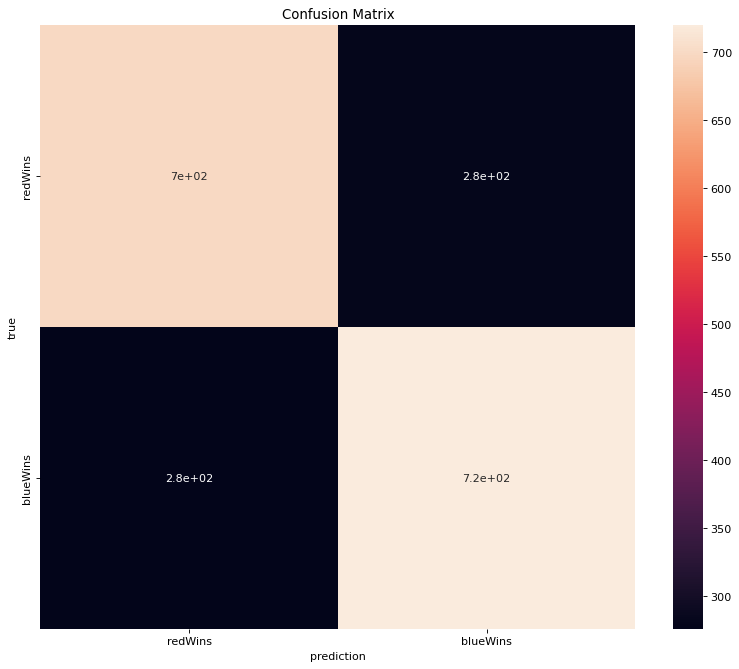

In [18]:
#test finale
svm_model_te = SVC(kernel= best_kernel_svm, C= maxC_svm, degree= best_degree)
svm_model_te.fit(X_tr_norm_last_final, t_tr_last)
t_pred_test = svm_model_te.predict(X_te_norm_final)   
f1score_test = f1_score(t_dev, t_pred_svm, average='macro')

print("the f1score on the test set is: ", f1score_test)

cm_test = confusion_matrix(t_te, t_pred_test)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm_test, annot=True, xticklabels=['redWins', 'blueWins'], yticklabels=['redWins', 'blueWins'])
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()